# Modelagem de Tópicos

### Bibliotecas importantes:

1. tm: https://cran.r-project.org/web/packages/tm/tm.pdf
2. topicmodels: https://cran.r-project.org/web/packages/topicmodels/topicmodels.pdf

### Importando bibliotecas a serem usadas

In [478]:
install.packages("topicmodels")
install.packages('SnowballC')
install.packages('tidytext')
install.packages("LDAvis")
install.packages("tsne")
install.packages("RCurl")
install.packages("xml2")
install.packages("wordcloud")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)
Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)
Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)
Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)
Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)
Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)
Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)
Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)


In [0]:
suppressMessages(suppressWarnings(library(topicmodels)))
suppressMessages(suppressWarnings(library(tm)))
suppressMessages(suppressWarnings(library(dplyr)))
suppressMessages(suppressWarnings(library(SnowballC)))
suppressMessages(suppressWarnings(library(stringr)))
suppressMessages(suppressWarnings(library(tidyr)))
suppressMessages(suppressWarnings(library(plyr)))
suppressMessages(suppressWarnings(library(reshape2)))
suppressMessages(suppressWarnings(library(ggplot2)))
suppressMessages(suppressWarnings(library(tidytext)))
suppressMessages(suppressWarnings(library(LDAvis)))
suppressMessages(suppressWarnings(library(RCurl)))
suppressMessages(suppressWarnings(library(xml2)))
suppressMessages(suppressWarnings(library(wordcloud)))

### Download dos dados
Importe aqui seu dataset de texto.

In [0]:
#Capturando notícias do G1 através da leitura do RSS disponibilizado

getDadosRss <- function(url,fonte) {
  
    doc <- read_xml(url)
  
    feed_title    <- xml_text(xml_find_all(doc,'//channel/title'))
    feed_link    <- xml_text(xml_find_all(doc,'//channel/link'))
    item_titles    <- xml_text(xml_find_all(doc,'//item/title'))
    item_description    <- xml_text(xml_find_all(doc,'//item/description'))
    item_link    <- xml_text(xml_find_all(doc,'//item/link'))
    item_data_published <- xml_text(xml_find_all(doc,'//item/pubDate'))
    item_category <- xml_text(xml_find_all(doc,'//item/category'))

    doc <- data.frame(feed_title=feed_title,feed_link=feed_link,item_titles=item_titles,
                       item_description=item_description,item_data_published=item_data_published,item_link=item_link,
                       item_category=item_category)
  
    # Removendo noticias que são chamadas para outras páginas
    doc <- doc %>% filter(!str_detect(doc$item_titles, "^VÍDEOS:"))
    doc <- doc %>% filter(!str_detect(doc$item_titles, "^VÍDEO:"))
    doc <- doc %>% filter(!str_detect(doc$item_titles, "^AO VIVO:"))
    doc <- doc %>% filter(!str_detect(doc$item_titles, "^Assista ao Jornal"))

    # Removendo link das imagens
    doc$item_description <- str_replace_all(doc$item_description, "<img\\ssrc.*/>","")

    # Removendo sentenças comuns a todos os textos
    remove_sentences <- function(x) {
      x <- str_replace_all(x,"Tem alguma notícia para compartilhar[?]","")
      x <- str_replace_all(x,"Envie para o Tô Na Rede!","")
      x <- str_replace_all(x,'"',"'")
      x <- str_replace_all(x,"‘","'")
      x <- str_replace_all(x,"’","'")
      x <- str_replace_all(x,"“","'")
      x <- str_replace_all(x,"”","'")
      x <- str_trim(x)
    }
  
    doc$fonte <- fonte
   
    doc$index <- seq(1:nrow(doc))
  
    doc$item_description <- lapply(doc$item_description,remove_sentences)
  
    doc$text <- paste0(doc$item_titles," ",doc$item_description)
  
    doc$document <- paste0(doc$fonte,"_",doc$index)
  
    doc
}

#Capturando notícias do G1 através da leitura de RSS
options(warn=-1)
dados <- getDadosRss("http://g1.globo.com/dynamo/politica/mensalao/rss2.xml","Fonte:Política")
dados <- bind_rows(dados,getDadosRss("http://g1.globo.com/dynamo/educacao/rss2.xml","Fonte:Educação"))
dados <- bind_rows(dados,getDadosRss("http://g1.globo.com/dynamo/ciencia-e-saude/rss2.xml","Fonte:Ciência e Saúde"))
dados <- bind_rows(dados,getDadosRss("http://g1.globo.com/dynamo/natureza/rss2.xml","Fonte:Natureza"))
dados <- bind_rows(dados,getDadosRss("http://g1.globo.com/dynamo/tecnologia/rss2.xml","Fonte:Tecnologia"))

dados_final <- dados %>% select(document,text)


In [539]:
head(dados_final)

document        
1 Fonte:Política_1
2 Fonte:Política_2
3 Fonte:Política_3
4 Fonte:Política_4
5 Fonte:Política_5
6 Fonte:Política_6
  text                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       

### Transforme seus dados em um corpus
Corpus é um conjunto de textos. Nesse contexto, corpus é o objeto da biblioteca tm criado para tratar os textos. 

In [540]:
source <- VectorSource(dados_final$text)
corpus <- Corpus(source)
corpus

inspect(corpus[1:length(corpus)])

<<SimpleCorpus>>
Metadata:  corpus specific: 1, document level (indexed): 0
Content:  documents: 188

<<SimpleCorpus>>
Metadata:  corpus specific: 1, document level (indexed): 0
Content:  documents: 188

  [1] STF perdoa pena de mais dois condenados no mensalão do PT com base no indulto de Temer Ex-sócios de Marcos Valério, os publicitários Cristiano Paz e Ramon Hollerbach tiveram as penas privativas de liberdade perdoadas pelo ministro Luís Roberto Barroso. Indulto de Temer dá perdão de pena a condenados no mensalão e na Lava Jato\nO ministro Luís Roberto Barroso, do Supremo Tribunal Federal (STF), perdoou a pena de mais dois condenados no julgamento do mensalão do PT com base no indulto natalino editado, em 2017, pelo então presidente da República, Michel Temer. Ex-sócios do empresário Marcos Valério, Cristiano Paz e Ramon Hollerbach tiveram extintas as penas privativas de liberdade, mas continuam com a obrigação de pagar a multa imposta pela Suprema Corte.\nPublicitário, Ramon Hollerbach foi condenado no julgamento do mensalão do PT a 27 anos, 4 meses e 20 dias de prisão pelos crime

### Qual a quantidade de documentos no seu corpus?

In [541]:
print(paste0("Neste exemplo e capturando as notícias fornecidas pelo G1 no instante de execução do script, temos um total de ",length(corpus)," documentos."))

[1] "Neste exemplo e capturando as notícias fornecidas pelo G1 no instante de execução do script, temos um total de 188 documentos."


### Preprocessando os dados
Realize aqui os pré-processamentos que você julgar necessário nesse corpus. **Explique suas escolhas.**

In [542]:
#Neste caso adotaremos como premissa serão case insensitive 
corpus <- tm_map(corpus, content_transformer(tolower))
#Outro ponto é a não consideração dos números pois em várias notícias estão citadas datas e valores que não são importantes para a definição do tópico em si
corpus <- tm_map(corpus, removeNumbers)
corpus <- tm_map(corpus, removePunctuation)
#Foram acrescentadas algumas stopwords adicionais depois de desenvolvida a primeira análise pois estavam distorcendo as métricas e não representando um
#ponto importante para a definição dos tópicos
stop_words <- c("segundo","ser","ainda","€","'","-","ª","ºc","º","mil","nº","dia","dias","ano","anos","disse","\"","r","g"," – ","após","deve",
                "dois","três","quatro","cinco","seis","sete","oito","nove","dez","segundafeira","terçafeira","quartafeira","quintafeira","sábado","domingo",
                "neste","podem","pode","acordo","durante","onde","deste","sobre","diz","ter","vai","nesta","fazer","além","outros","apenas","desde",
                "sendo","porque","junho","julho","menos","outras","maior","cada","têm","forma","parte","afirmou","vez","veja","todos","cerca","antes","todo")
corpus <- tm_map(corpus, removeWords, c(stop_words,stopwords('portuguese'),stopwords('english')))
#Retirando os espaços
corpus <- tm_map(corpus, stripWhitespace)

inspect(corpus[1:10])

<<SimpleCorpus>>
Metadata:  corpus specific: 1, document level (indexed): 0
Content:  documents: 10

 [1] stf perdoa pena condenados mensalão pt base indulto temer exsócios marcos valério publicitários cristiano paz ramon hollerbach penas privativas liberdade perdoadas ministro luís roberto barroso indulto temer dá perdão pena condenados mensalão lava jato ministro luís roberto barroso supremo tribunal federal stf perdoou pena condenados julgamento mensalão pt base indulto natalino editado então presidente república michel temer exsócios empresário marcos valério cristiano paz ramon hollerbach extintas penas privativas liberdade continuam obrigação pagar multa imposta suprema corte publicitário ramon hollerbach condenado julgamento mensalão pt meses prisão crimes corrupção ativa evasão divisas lavagem dinheiro peculato condenado meses reclusão cristiano paz é publicitário acusado procuradoriageral república pgr atuar obtenção empréstimos fraudulentos alimentavam esquema mensalão pt paz

### Crie sua matriz termo-documento. Quantos termos você possui no seu vocabulário?

In [543]:
#Utilizando o peso TF
mat <- DocumentTermMatrix(corpus, control = list(weighting = weightTf))
mat

<<DocumentTermMatrix (documents: 188, terms: 13931)>>
Non-/sparse entries: 41567/2577461
Sparsity           : 98%
Maximal term length: 33
Weighting          : term frequency (tf)

In [544]:
dim(mat)

mat_nosparse <- removeSparseTerms(mat, 0.99)

dim(as.matrix(mat_nosparse))

wordcount <- colSums(as.matrix(mat_nosparse))
topten <- head(sort(wordcount, decreasing=TRUE), 10)

[1]   188 13931

[1]  188 5875

Verificando a frequência das palavras dentro do corpus:

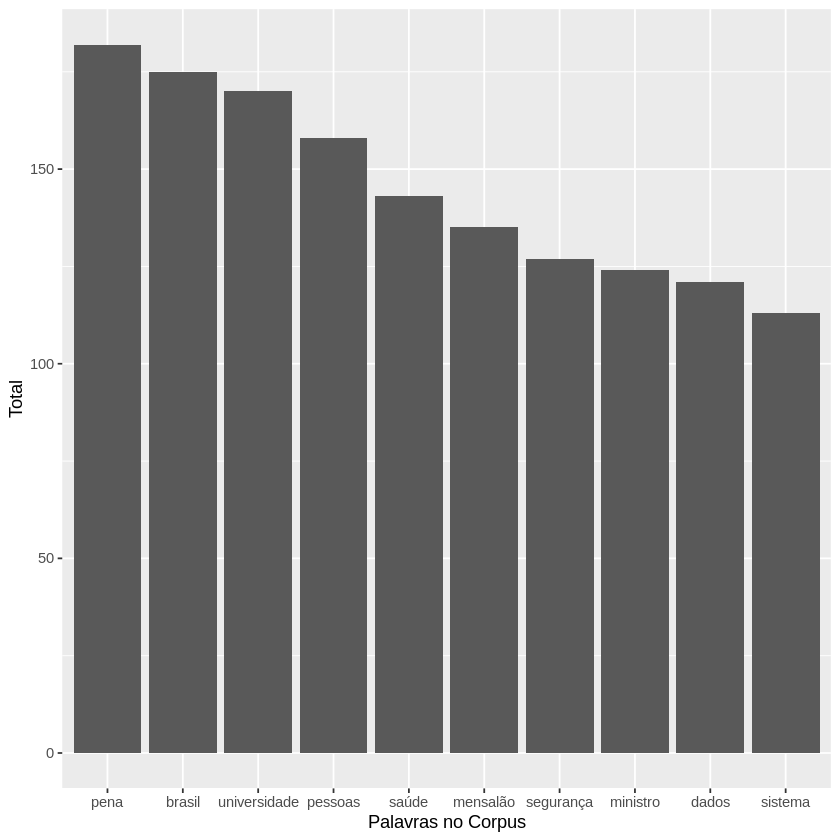

In [545]:
dfplot <- as.data.frame(melt(topten))
dfplot$word <- dimnames(dfplot)[[1]]
dfplot$word <- factor(dfplot$word,
                      levels=dfplot$word[order(dfplot$value,
                                               decreasing=TRUE)])

fig <- ggplot(dfplot, aes(x=word, y=value)) + geom_bar(stat="identity")
fig <- fig + xlab("Palavras no Corpus")
fig <- fig + ylab("Total")
print(fig)

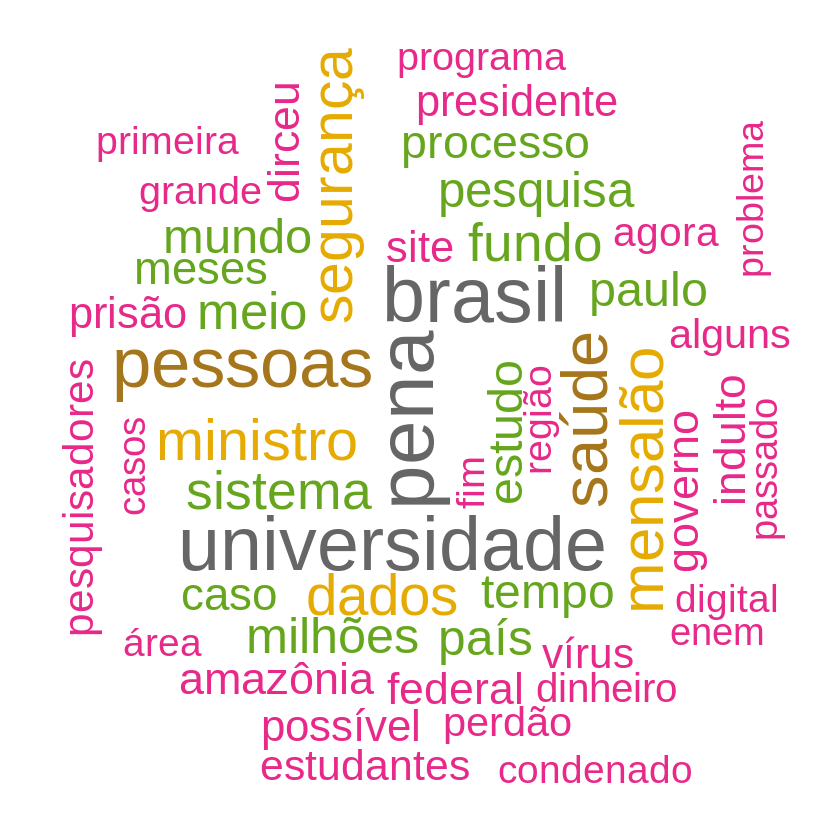

In [546]:
freq = data.frame(sort(colSums(as.matrix(mat_nosparse)), decreasing=TRUE))
wordcloud(rownames(freq), freq[,1], min.freq = 1,max.words=50, random.order=FALSE, 
          rot.per=0.15,colors=brewer.pal(8, "Dark2"))

In [547]:
print(paste0("A matriz termo-documento possui ",dim(mat_nosparse)[2]," termos."))

[1] "A matriz termo-documento possui 5875 termos."


### Descubra o número de tópicos no seu documento. Justifique cada passa e a sua escolha.

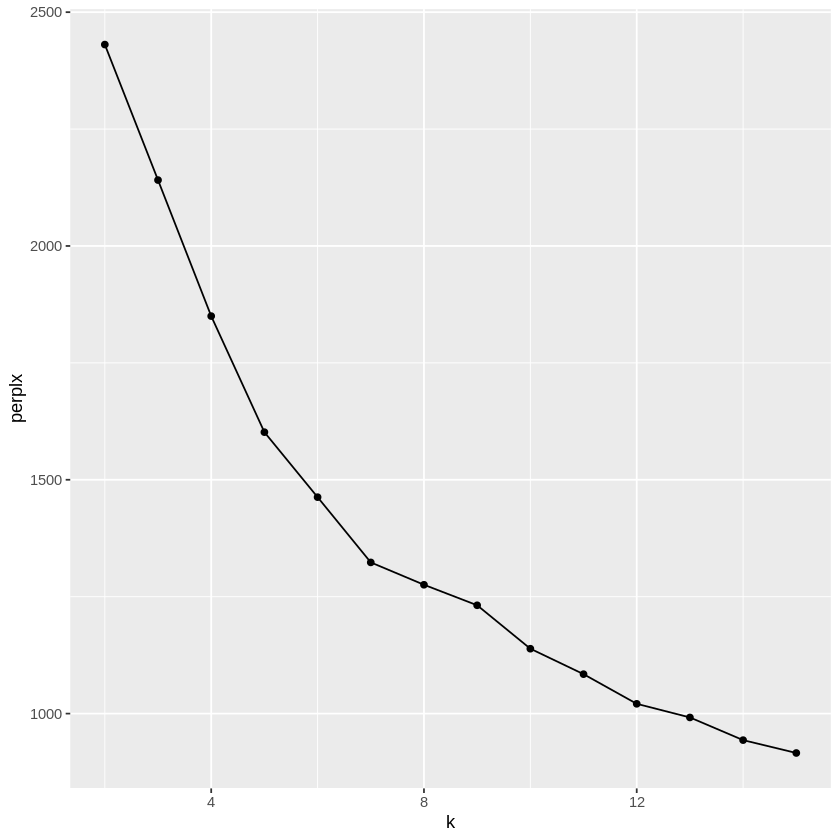

In [529]:
#Criada o gráfico de perplexidade de acordo com o valor k (tópicos) variando de 2 a 15 por exemplo
#pode-se estimar o valor de k que represente ainda um ganho relevante com o aumento do número de tópicos 
k <- c(2:15)
perplx <- c()

for (i in k){
  lda <- LDA(mat_nosparse, k = i)
  perplx <- c(perplx, perplexity(lda, newdata = mat_nosparse))
}

ggplot() +
  geom_line(aes(x=k, y=perplx)) +
  geom_point(aes(x=k, y=perplx))

Pela curva vê-se que até o valor de k igual a 5 tem-se uma queda da perplexidade acentuada, para em seguida diminuir um pouco a inclinação da curva até k igual a 7 e reduzindo mais fortemente a prtir daí.

Neste caso, iremos considerar o valor de k igual a 5 afim de não aumentar a complexidade da análise com um aumento de mais 2 tópicos.
Além disso por termos capturado os textos do G1 com uma pré-identificação, tudi indica que o valor de 5 realmente pode ser a escolha mais adequada.


### Faça a análise dos tópicos criados com o número escolhido acima. Na sua análise apresente os termos mais importantes para cada tópico, nomeie cada tópico e apresente exemplos de documentos que se encaixem muito bem no tópico e outros que nem tanto. Pode adicionar outras informações que achar relevante para que o leitor entenda o que está acontecendo nos seus tópicos.



In [548]:
#Nomeando documentos
rownames(mat_nosparse) <- dados_final$document
lda <- LDA(mat_nosparse, k = 5, control = list(seed = 1234))
lda

A LDA_VEM topic model with 5 topics.

In [549]:
n_topics <- tidy(lda, matrix = "beta")

top_terms <- n_topics %>%
  group_by(topic) %>%
  top_n(5, beta) %>%
  ungroup() %>%
  arrange(topic, -beta)

terms(lda, 5)

Topic 1,Topic 2,Topic 3,Topic 4,Topic 5
florestas,segurança,pena,universidade,saúde
árvores,dados,mensalão,enem,pessoas
pesquisadores,vírus,ministro,estudantes,pele
milhões,celular,fundo,alunos,médicos
parque,facebook,dirceu,prova,mulheres


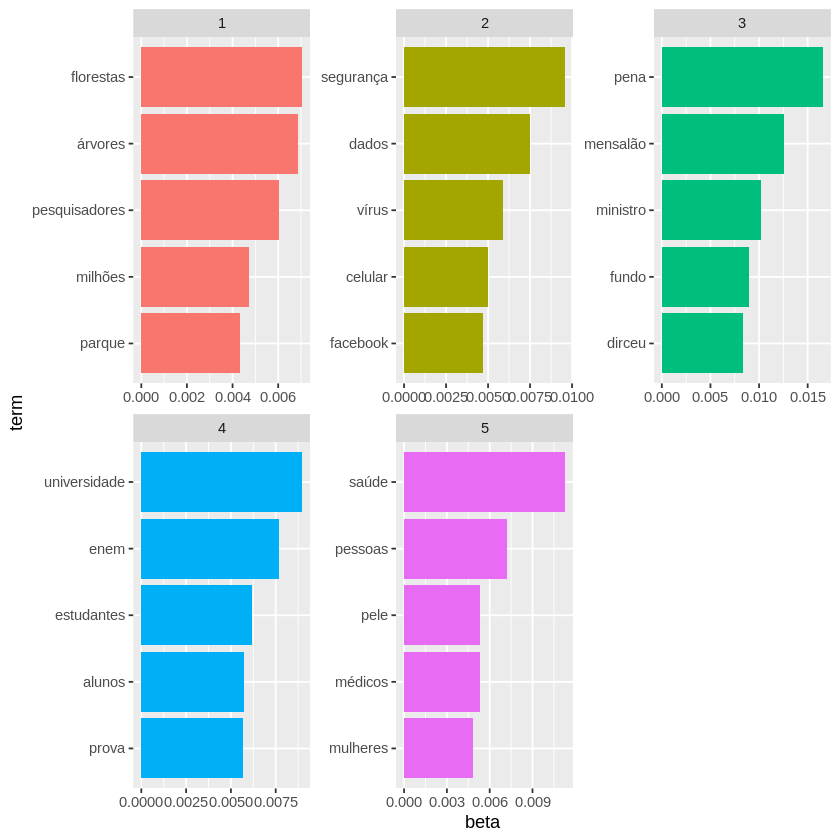

In [550]:
top_terms %>%
  mutate(term = reorder(term, beta)) %>%
  ggplot(aes(term, beta, fill = factor(topic))) +
  geom_col(show.legend = FALSE) +
  facet_wrap(~ topic, scales = "free") +
  coord_flip()

De acordo com o grupo de palavras principais fornecidas por tópico há uma tendência que sejam relacionados ao assuntos abaixo:

* Tópico 1   - Natureza
* Tópico 2   - Tecnologia
* Tópico 3   - Política
* Tópico 4   - Educação
* Tópico 5   - Ciência e Saúde

Documentos por Tópico

Fonte,Indice,topic,gamma
<chr>,<int>,<int>,<dbl>
Fonte:Política,1,1,4.601744e-05
Fonte:Política,2,1,1.455296e-04
Fonte:Política,3,1,1.076955e-04
Fonte:Política,4,1,1.466747e-04
Fonte:Política,5,1,1.293701e-04
Fonte:Política,6,1,3.727576e-05
Fonte:Política,7,1,5.249707e-05
Fonte:Política,8,1,8.872897e-05
Fonte:Política,9,1,6.515832e-05


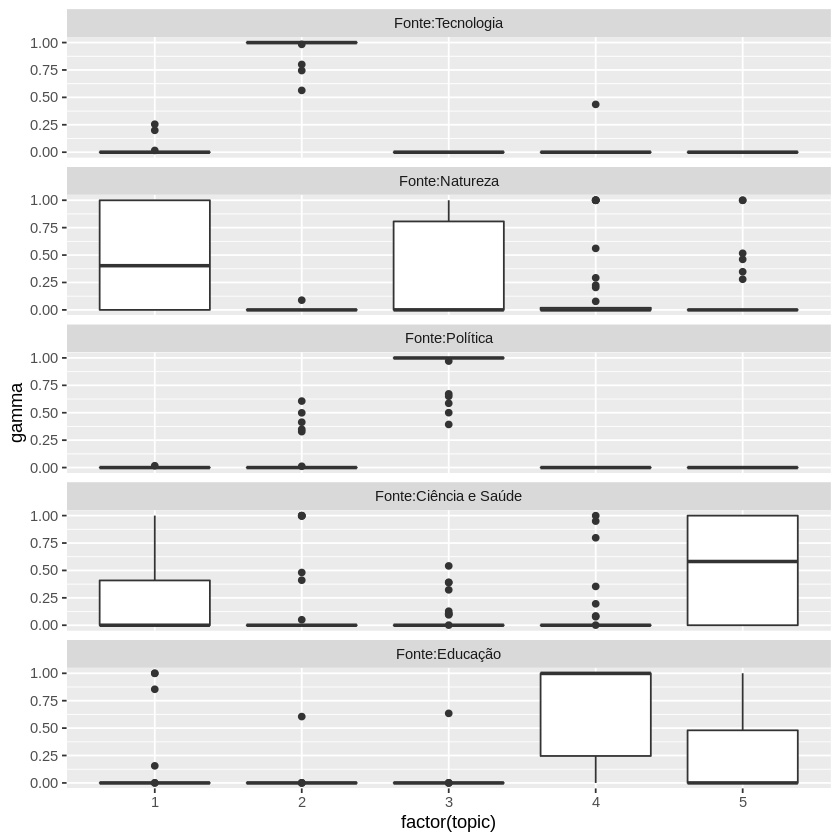

In [553]:
doc_gamma <- tidy(lda, matrix = "gamma")
doc_gamma <- doc_gamma %>% separate(document, c("Fonte", "Indice"), sep = "_", convert = TRUE)

doc_gamma

doc_gamma %>%
  mutate(title = reorder(Fonte, gamma * topic)) %>%
  ggplot(aes(factor(topic), gamma)) +
  geom_boxplot() +
  facet_wrap(~ title,ncol=1)

In [0]:
label_topicos <- c("Natureza","Tecnologia","Política","Educação","Ciência e Saúde")

In [555]:
# Fazendo a correlação entre os tópicos encontrados por documento
item_classifications <- doc_gamma %>%
  group_by(Fonte, Indice) %>%
  top_n(1, gamma) %>%
  ungroup()


colnames(item_classifications) <- c("Fonte", "Indice", "topics", "gamma")
item_classifications



Fonte,Indice,topics,gamma
<chr>,<int>,<int>,<dbl>
Fonte:Educação,13,1,0.8543197
Fonte:Educação,19,1,0.9997741
Fonte:Educação,39,1,0.9997030
Fonte:Ciência e Saúde,2,1,0.9991903
Fonte:Ciência e Saúde,5,1,0.9994312
Fonte:Ciência e Saúde,11,1,0.9996868
Fonte:Ciência e Saúde,19,1,0.5114367
Fonte:Ciência e Saúde,28,1,0.4994590
Fonte:Ciência e Saúde,33,1,0.9997935


In [556]:
doc_topics <- item_classifications
doc_topics <- count(doc_topics, vars=c('Fonte', 'topics')) %>%
  group_by(Fonte) %>%
  top_n(1, 4) %>%
  ungroup() %>%
  transmute(Consensus = Fonte, topics)

item_classifications %>%
  inner_join(doc_topics, by = "topics") %>%
  filter(Fonte != Consensus)

Fonte,Indice,topics,gamma,Consensus
<chr>,<int>,<int>,<dbl>,<chr>
Fonte:Educação,13,1,0.8543197,Fonte:Ciência e Saúde
Fonte:Educação,13,1,0.8543197,Fonte:Natureza
Fonte:Educação,19,1,0.9997741,Fonte:Ciência e Saúde
Fonte:Educação,19,1,0.9997741,Fonte:Natureza
Fonte:Educação,39,1,0.9997030,Fonte:Ciência e Saúde
Fonte:Educação,39,1,0.9997030,Fonte:Natureza
Fonte:Ciência e Saúde,2,1,0.9991903,Fonte:Educação
Fonte:Ciência e Saúde,2,1,0.9991903,Fonte:Natureza
Fonte:Ciência e Saúde,5,1,0.9994312,Fonte:Educação


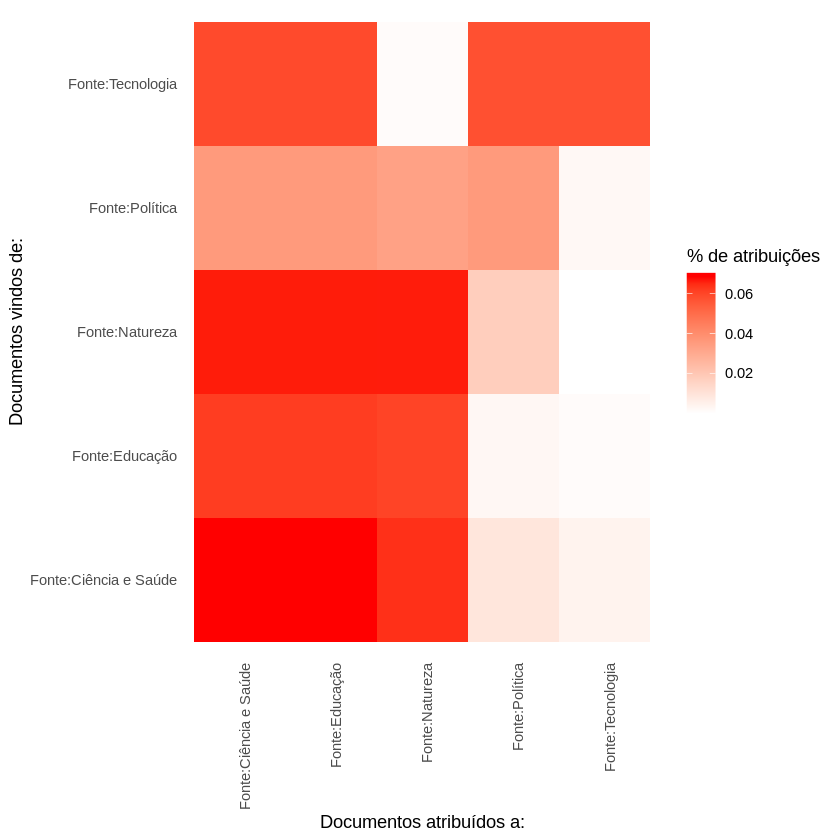

In [560]:
assignments <- augment(lda, data = mat_nosparse)
assignments <- assignments %>%
  separate(document, c("Fonte", "Indice"), sep = "_", convert = TRUE) %>%
  inner_join(doc_topics, by = c(".topic" = "topics"))

assignments <- count(assignments, vars=c('Fonte', 'Consensus')) %>%
  group_by(Fonte) %>%
  mutate(percent = freq / sum(freq)) %>%
  ggplot(aes(Consensus, Fonte, fill = percent)) +
  geom_tile() +
  scale_fill_gradient2(high = "red") +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 90, hjust = 1),
        panel.grid = element_blank()) +
  labs(x = "Documentos atribuídos a:",
       y = "Documentos vindos de:",
       fill = "% de atribuições")
assignments

Analisando as previsões de associação dos documentos aos tópicos e ao tema definido dos mesmos, vemos que a taxa de atribuição correta para alguns temas é maior, como por exemplo associados à "Ciência e Saúde" e "Natureza", porém o que mais se nota é uma composição entre os temas.

Pode-se observar também que o tema "Tecnologia" foi o que mais permeou os demais temas, sugerindo que todos os demais possuem uma parcela deste tópico em suas composições.







## Referências

1. https://rstudio-pubs-static.s3.amazonaws.com/163802_0f005a14bcfb4c4b8ee17ac8a8e6c3e9.html
2. https://www.tidytextmining.com/topicmodeling.html#lda-on-chapters
3. http://freerangestats.info/blog/2017/01/05/topic-model-cv
